## Symbolic representation of chemical kinetics
As we saw in the previous notebook, the rate of chemical reactions can be described by ordinary differential equations.

In this notebook we will look at a classic example in chemical kinetics:
[Robertson's example](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.53.8603).
It is a 3-species reaction system:

$$
A \overset{k_1}{\rightarrow} B \\
B + C \overset{k_2}{\rightarrow} A + C \\
2 B \overset{k_3}{\rightarrow} B + C
$$

where A, B and C represent three different chemical species (e.g. reactive molecules dissolved in water). The system is interesting from a numerical point of view because the stepping needs to be performed using an implicit method (requiring the Jacobian) when solving for large times.

The rate of each process follows the [law of mass action](https://en.wikipedia.org/wiki/Law_of_mass_action), i.e. the rate is proportional to the concentration of each reacting species (to the power of their multiplicity). The proportionality constant is known as the rate constant of the reaction ($k_1,\ k_2\ \&\ k_3$ in our case). If we denote the rate of each reaction:

$$
r_1 = k_1[A] \\
r_2 = k_2[B][C] \\
r_3 = k_3[B]^2
$$

$[A],\ [B],\ [C]$ denotes the concentration of respective species. We can now formulate a system of ordinary differential equations describing how the concentrations evolve over time:

$$
\frac{d[A]}{dt} = r_2 - r_1 \\
\frac{d[B]}{dt} = r_1 - r_2 - r_3 \\
\frac{d[C]}{dt} = r_3
$$

We will now express these differential equations (and their Jacobian) symbolically using SymPy. We saw in the previous notebook how we can use matrices with integer coefficients to describe the system of ODEs. In practice, those matrices, will consist of mostly zeros. So dictionaries are a better suited data structure (using dictionaries is one way to represent sparse matrices).

Let us therefore write a function, which creactes SymPy expressions from dictionaries mapping strings (names) to integers (coefficients). Here is one possible representation of Robertson's example:

In [1]:
reactions = [
    ('k1', {'A': 1}, {'B': 1, 'A': -1}),
    ('k2', {'B': 1, 'C': 1}, {'A': 1, 'B': -1}),
    ('k3', {'B': 2}, {'B': -1, 'C': 1})
]
names = 'A B C'.split()

## Exercise: Create SymPy expressions from simple data structures
You will need to complete ``mk_exprs_symbs`` (replace **???** with valid expression) which constructs symbolic expressions following the law of mass action.

In [2]:
%load_ext scipy2017codegen.exercise

Use either the ``%exercise`` or ``%load`` magic to get the exercise / solution respectively:

In [9]:
# %exercise exercise_symbolic.py
from operator import mul
from functools import reduce
import sympy as sym

def prod(seq):
    return reduce(mul, seq) if seq else 1

def mk_exprs_symbs(rxns, names):
    symbs = sym.symbols(names, real=True, nonnegative=True)
    c = dict(zip(names, symbs))
    f = {n: 0 for n in names}
    k = []
    for coeff, r_stoich, net_stoich in rxns:
        k.append(sym.S(coeff))
        r = k[-1]*prod([c[rk]**p for rk, p in r_stoich.items()])
        for net_key, net_mult in net_stoich.items():
            f[net_key] += r*net_mult
    return [f[n] for n in names], symbs, tuple(k)


To complete the above exercise you may want to remember what the law of mass action looks like from the previous notebook:

$$
\frac{dc_i}{dt} = \sum_j S_{ij} r_j \\
r_j = k_j\prod_l c_l^{R_{jl}}
$$

where $k_j$, S and R corresponds to ``coeff``, ``net_stoich`` and ``r_stoich`` respectively.

In [10]:
sym.init_printing()
ydot, y, k = mk_exprs_symbs(reactions, names)
ydot

$\dot{\mathbf{y}}$ now represent our ODE system, where $\mathbf{y}$ is our state vector (concentrations). We will need a callback to evaluate $\dot{\mathbf{y}}$ when we integrate this ODE system numerically (using ``scipy.integrate.odeint``). As we have seen SymPy can provide us with this callback:

In [11]:
t = sym.symbols('t')  # not used in this case.
f = sym.lambdify((y, t) + k, ydot)

In [12]:
import numpy as np
from scipy.integrate import odeint

In [13]:
tout = np.logspace(-6, 6)
k_vals = (0.04, 1e4, 3e7)  # from the literature
y0 = [1, 0, 0]
yout, info = odeint(f, y0, tout, k_vals, full_output=True)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

The Jacobian was evaluated 82 times.


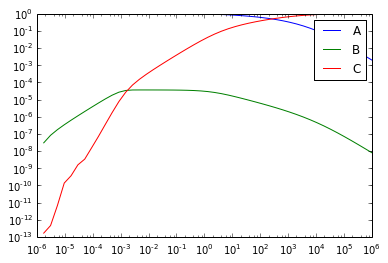

In [15]:
plt.loglog(tout, yout)
plt.legend(names)
print("The Jacobian was evaluated %d times." % info['nje'][-1])



If we look closer at the info-dictionary we will see that odeint (or rather LSODA which is the unerlying package) switched method from an explicit Adams method to an implicit Backward Differentiation Formula (BDF). It is common for chemical kinetics problems that the problem becomes stiff.

By default, the solver will approximate the elements in the Jacobian matrix by taking finite differences of $\mathbf{f}$. This is often works quite satisfactorily, but for larger systems it sometimes fails. A more robust (and faster) approach is to provide a callback which evaluates an analytic Jacobian. Using SymPy we can do this quite effortlessly:

## Exercise: Derive a Jacobian symbolically and generate a function evaluating it
You may want to consult ``help(odeint)`` for the requested function signature of ``Dfun``.

In [20]:
# %exercise exercise_lambdify_jac.py
J = sym.Matrix(ydot).jacobian(y)
J_cb = sym.lambdify((y, t) + k, J)


In [21]:
yout, info = odeint(f, y0, tout, k_vals, full_output=True, Dfun=J_cb)

The Jacobian was evaluated 82 times.


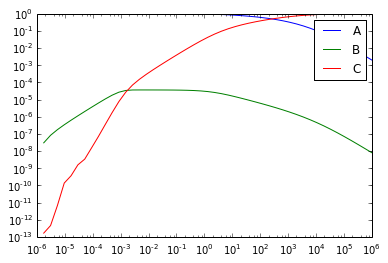

In [22]:
plt.loglog(tout, yout)
plt.legend(names)
print("The Jacobian was evaluated %d times." % info['nje'][-1])

We see that the solver needed to evaluate the Jacobian fewer times (due to it being essentially exact this time around). For larger systems the impact of an analytic Jacobian is often even greater (being the difference between a failed and successful integration). 

Benchmarking with and without the analytic Jacobian callback:

In [23]:
%timeit odeint(f, y0, tout, k_vals)

10 loops, best of 3: 43.3 ms per loop


In [24]:
%timeit odeint(f, y0, tout, k_vals, Dfun=J_cb)

10 loops, best of 3: 45.2 ms per loop
